In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.signal import convolve
from scipy import stats
from sympy import symbols, solve, Eq, Function, nsolve
from sympy.matrices import Matrix
import sympy as sp
from TCSPC import *
from scipy.optimize import curve_fit
from lmfit import Model, Parameters
import lmfit
import inspect
import pandas as pd

### Monte Carlo method

Draw `n_photon` random variables (time) from a mono exponential probability density function(pdf)
$$f(t) = 1/\tau \cdot \exp{(-t/\tau)}$$
where $\tau$ is the lifetime (also mean). `rng.exponential()` is used to generate `n_photon` arrival times.

For simulating data of multi exponential decays with the form
$$N(t) = \sum_i A_i \exp{(-t/\tau_i)}$$
where $N$ is the number of photons, $A_i$ and $\tau_i$ is amplitude and lifetime of the $i$ th component
The pdf now becomes 
$$f(t) = \sum_i B_i \cdot f_i(t) = \sum_i B_i /\tau_i \cdot \exp{(-t/\tau_i)}$$
where $f_i$ is the exponential pdf for each component, and $B_i$ is the weighting. To recover the distribution in the simulation data $N(t)$, we set $B_i = A_i \cdot \tau_i$.

`rng.choice()` is used to generate an array of lifetimes of length `n_photon`, where the occurence is weighted by probabilities $A_i \tau_i$. `rng.exponential()` is then used to generate `n_photon` arrival times.

Arrival times are then binned to give decay curves

In [2]:
NADH = Simulation([0.75,0.25],[0.4,4]) #create sim instance of simulation class
EGFP = Simulation([0.503,0.497],[3.07,2.43]) #EGFP
mCherry  = Simulation([0.83,0.17],[1.43,2.38]) #mCherry
demo_tau = np.linspace(0.2,2,10) #lifetime from 0.2 to 2 ns as demonstration
demo_amp = np.ones(10)/10
DEMO = Simulation(demo_amp,demo_tau)

#### Comparison of simulation data from Monte Carlo (MC) method and adding Poisson noise to exponential curve convolved with very sharp IRF

The data generated by both methods are similar

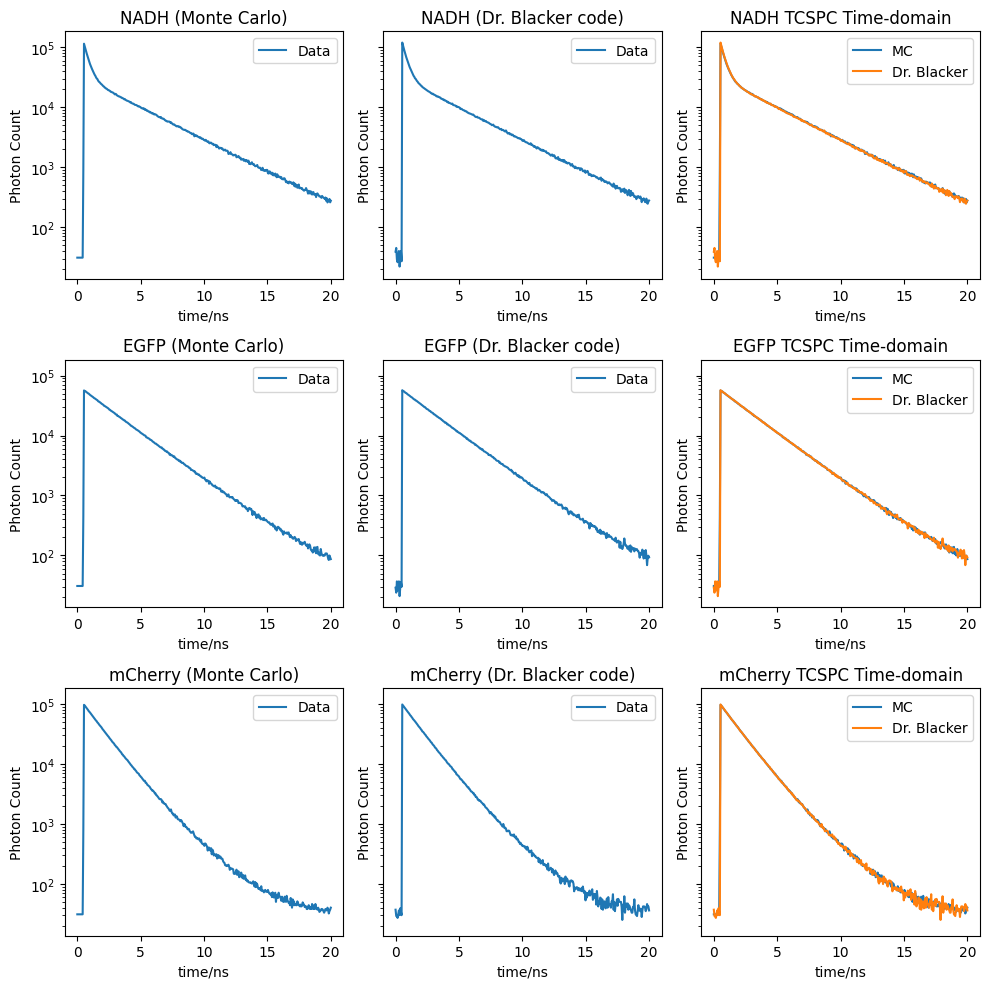

In [9]:
fig,ax = plt.subplots(3,3,figsize = (10,10),sharey = True)
ax = np.array(ax).flatten()
sim_list = [NADH,EGFP,mCherry] #list of Simulation class objects
sim_name = ['NADH','EGFP','mCherry'] #list of names for the Simulations
for i in range(3):
    sim = sim_list[i]
    sim.plot(ax[i*3],sim.y)
    sim.plot(ax[1+i*3],sim.y2)
    sim.plot(ax[2+i*3],sim.y)
    sim.plot(ax[2+i*3],sim.y2)
    ax[i*3].set_title(f'{sim_name[i]} (Monte Carlo)')
    ax[i*3+1].set_title(f'{sim_name[i]} (Dr. Blacker code)')
    ax[i*3+2].set_title(f'{sim_name[i]} TCSPC Time-domain')
    handles, labels = ax[2+i*3].get_legend_handles_labels()
    labels = ['MC','Dr. Blacker']
    ax[i*3+2].legend(labels)
plt.tight_layout()

### DEMO

#### Brief Introduction to Simulation class object:

Input: <ul>
       <li>amp - an array of amplitudes/fractional intensity of mono-exponential components</li>
       <li>tau - an array of lifetimes of mono-exponential components</li>
       <li>IRF characteristics e.g. offset, irfwidth, bg, run_time can be modified,
       but have default values as in the given script</li>
       <li>Histogram properties, e.g. window - time-axis range (0-20ns), n_bins - number of bins (default 380)</li>
       </ul>
Methods: 

* `multi_exp_data` generate 1 multi exponential curve (1d array of size n_bins)\
* `MC_exp` : generate an array of mono exponential decay curves or 1 multi exponential curve using Monte Carlo method (i.e. random number generator, drawing from normal (IRF) and exponential distribution (decay))
* `plot`   : Plot the generated data. Need to pass a matplotlib `ax` object for plotting and y array (data to be plotted).\
Select data simulation function by setting MC =True (`MC_exp`) or False (`multi_exp_data`)

Call the `MC_exp()` method first to get data stored in `self.y`\
`multi_exp_data` would be stored in `self.y2`


### Deconvolution for non-linear fitting

Note at around 20ns, boundary effects, low-count statistic and noise would result in such poor behaviour. The deconvolved data should be trimmed before fitting

Discussed in meeting on 8 Frb, deconvolution using FFT is not recommended, as it might produce some unwanted artifects. Just use trimmed data for fitting 

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 1.0, 'Multi-exp')

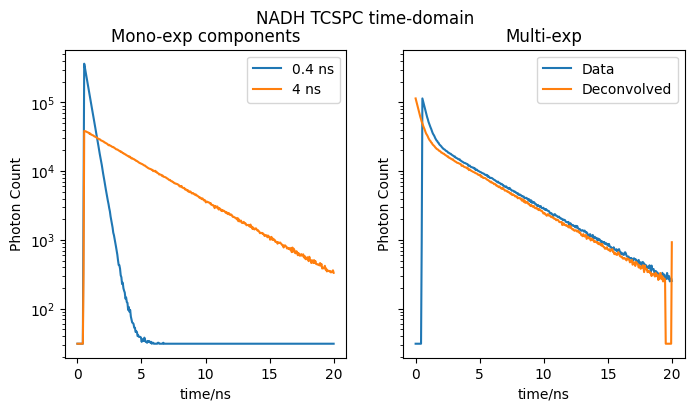

In [4]:
t, y_NADH = NADH.MC_exp()
fig,ax = plt.subplots(1,2,sharey = True, figsize = (8,4))
plt.suptitle('NADH TCSPC Time-domain Simulation')
NADH.plot(ax[0],NADH.y_arr) #plot mono exp component
NADH.plot(ax[1],NADH.y) #plot multi exp 
NADH.plot(ax[1],NADH.y,deconv=True) #plot data deconvolved with IRF
handles, labels = ax[1].get_legend_handles_labels()
labels[-1] = 'Deconvolved'
ax[1].legend(labels)
ax[0].set_title('Mono-exp components')
ax[1].set_title('Multi-exp')

### Non-linear curve fit

1. Mono-exponential decay

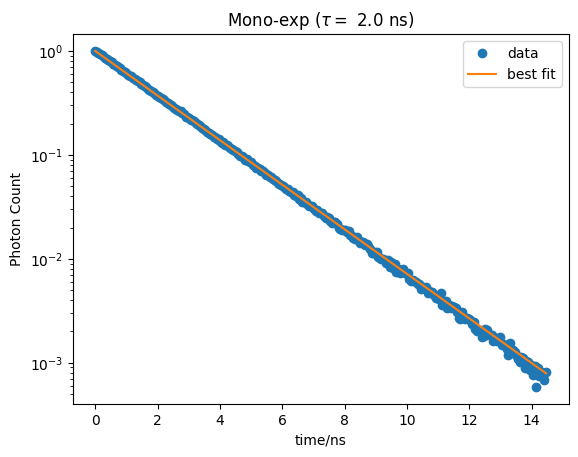

In [5]:
fig,ax = plt.subplots()
DEMO.fit(exp1,DEMO.y_arr[9],plot = True, guess = [DEMO.tau[9]],ax=ax) #fit and plot fitted curve
ax.set_title(rf'Mono-exp ($\tau =$ {DEMO.tau[9]} ns)')
DEMO.fit_result

2. Multi-exponential decay

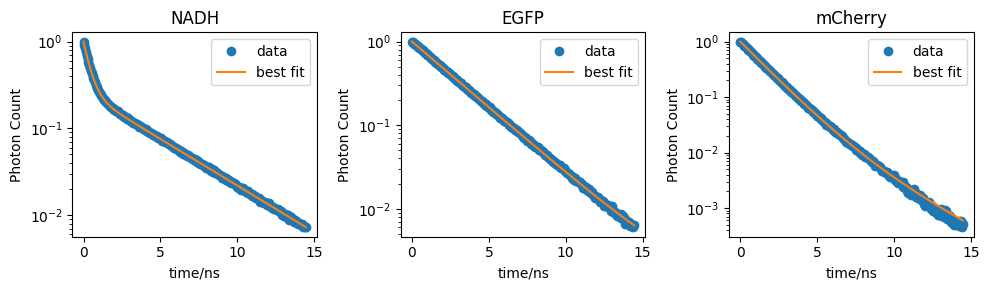

In [6]:
fig, ax = plt.subplots(1,3,figsize = (10,3))
NADH.fit(exp2,plot = True,ax=ax[0])
ax[0].set_title(rf'NADH')
EGFP.fit(exp2,plot = True,ax=ax[1])
ax[1].set_title(rf'EGFP')
mCherry.fit(exp2,plot = True,ax=ax[2])
ax[2].set_title(rf'mCherry')
plt.tight_layout()

In [7]:
pd.set_option('display.float_format', '{:.3g}'.format)
results = [NADH.fit_result,EGFP.fit_result, mCherry.fit_result] #list of ModelResult objects
def fit_df(results):
    '''Generates an info_df and par_df to store fitted parameters and chi2
       Input:
       results    list of lmfit ModelResult objects 
       output:
       info_df (information dataframe), par_df (parameter dataframe)
       '''
    
    # Extract the information from the result objects
    par_col = ['_val','init_value','stderr','correl'] #column names for parameter dataframe
    attribute_names = ['chisqr', 'redchi'] + par_col
    info_dict = {attribute_name: [] for attribute_name in attribute_names}
    par_df = pd.DataFrame()

    for result in results:
        #create data frame storing parameters
        par_df_new = pd.concat({k: pd.Series(vars(v)).T for k, v in result.params.items()}, axis=1) #parameter attributes in pd.DataFrame
        par_df_new = par_df_new.loc[par_col] #select value, initial value, error, and correlation 
        par_df_new.loc['correl'] = [{k : f'{float(v):.3g}' for k,v in pair.items() }for pair in  par_df_new.loc['correl'].values] #round correlations
        #append the new df to exisiting df
        par_df = pd.concat([par_df,par_df_new])
        info_dict['chisqr'].append(result.chisqr) #chi2
        info_dict['redchi'].append(result.redchi) #reduced chi2
        for col in par_col[:-1]:
            info_dict[col].append([f'{v:.3g}' for v in par_df_new.T[col].values]) #store as list in this data frame
        info_dict['correl'].append(par_df_new.T['correl'].values) #correlation dictionary
    info_df = pd.DataFrame(info_dict) 
    return info_df, par_df

In [8]:
info_df, par_df = fit_df(results)
info_df

,chisqr,redchi,_val,init_value,stderr,correl
0,0.000395,1.45e-06,"[0.74, 0.409, 4.04]","[0.75, 0.4, 4]","[0.000594, 0.000759, 0.0092]","[{'tau1': '0.766', 'tau2': '0.877'}, {'A1': '0..."
1,0.00127,4.66e-06,"[0.00108, 391, 2.76]","[0.503, 3.07, 2.43]","[0.0016, 1.73e+04, 0.00607]","[{'tau1': '-0.989', 'tau2': '-0.948'}, {'A1': ..."
2,0.000466,1.71e-06,"[0.94, 1.52, 3.06]","[0.83, 1.43, 2.38]","[0.0126, 0.00835, 0.211]","[{'tau1': '0.985', 'tau2': '0.988'}, {'A1': '0..."


Note that failure to resolve EGFP lifetimes (fitting as if it is mono-exp)

In [9]:
print(NADH.fit_report)
print('-----------------------------------------------------')
print(EGFP.fit_report)
print('-----------------------------------------------------')
print(mCherry.fit_report)

[[Model]]
    Model(exp2)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 275
    # variables        = 3
    chi-square         = 3.9526e-04
    reduced chi-square = 1.4532e-06
    Akaike info crit   = -3693.49946
    Bayesian info crit = -3682.64915
[[Variables]]
    A1:    0.73983847 +/- 5.9442e-04 (0.08%) (init = 0.75)
    tau1:  0.40911166 +/- 7.5903e-04 (0.19%) (init = 0.4)
    tau2:  4.03995458 +/- 0.00919997 (0.23%) (init = 4)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, tau2)   = 0.877
    C(A1, tau1)   = 0.766
    C(tau1, tau2) = 0.611
-----------------------------------------------------
[[Model]]
    Model(exp2)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 205
    # data points      = 275
    # variables        = 3
    chi-square         = 0.00126816
    reduced chi-square = 4.6624e-06
    Akaike info crit   = -3372.91323
    Bayesian info crit = -3362.06292
[[Variabl

### Effect of trimming  In FFT

The data is trimmed to $8 \tau$ as beyond that bg > emitted photon

Note that FFT of trimmed data is almost the same as FFT of original data, and even contain less data points
Both FFT curves deviates from the analytic solution of the Fourier Transform, which may be an artifect of using Discrete transform with not enough data points. Also this may be a result of noise in the data.

Therefore for phasor plots the data will not be trimmed

### Effect of lifetime
Agreement with analytic solution increases with lifetime 

### Effect of bin size
Agreement with analytic solution decreases with bin size (increases with bin number). However bin size cannot be changed in experimental setup.

Text(0, 0.5, 'Imaginary component of FFT')

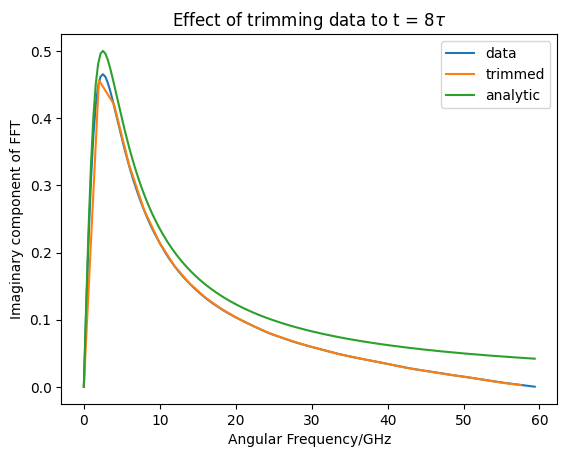

In [10]:
w, p = NADH.phasor_fft(multi = False)
w = w[:int(len(w)/2)]
tau0 = NADH.tau[0]
end = int(tau0*8*NADH.n_bins/NADH.window)
#trim data to 8 tau
y_trim = NADH.y_arr[0,:end]
ker_trim = NADH.ker[:end]
#FFT 
p2 = np.fft.fft(y_trim)/np.sum(y_trim)/np.fft.fft(ker_trim)*np.sum(ker_trim)
w2 = 2*np.pi*np.fft.fftfreq(len(ker_trim),NADH.t[end]/len(ker_trim))
p2 = p2[:int(len(w2)/2)] #just get +ve freq
w2  = w2[:int(len(w2)/2)]

plt.title(r'Effect of trimming data to t = 8$\tau$')
for i in range(1):
    plt.plot(w,-np.imag(p[i,:len(w)]),label = 'data')
    plt.plot(w2,-np.imag(p2),label = 'trimmed')
    plt.plot(w, np.imag(exp_FT(w,NADH.tau)[i]),label = 'analytic')
plt.legend()
plt.xlabel('Angular Frequency/GHz')
plt.ylabel('Imaginary component of FFT')

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

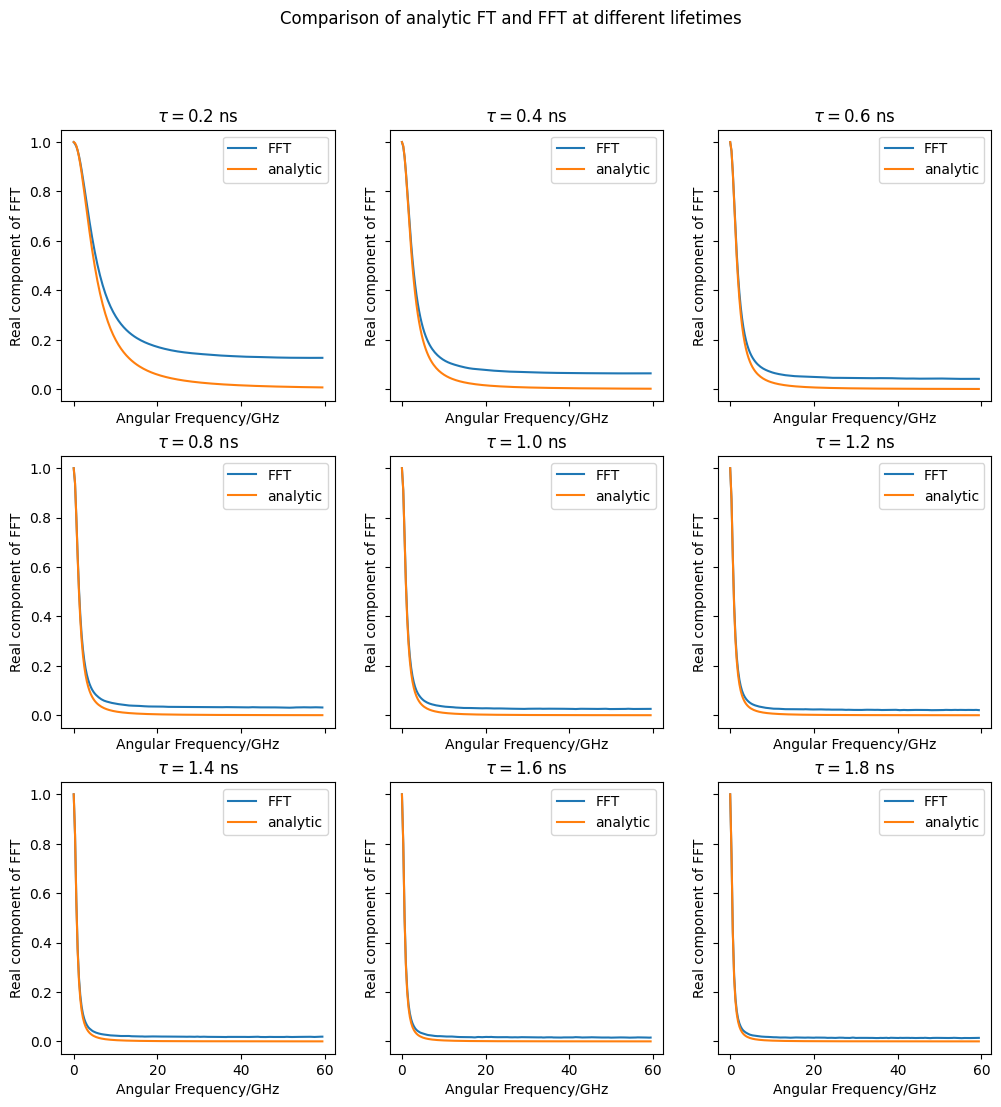

In [11]:
w,p = DEMO.phasor_fft(multi = False)
w = w[:190]
p = p[:,:190]
fig, ax_fft = plt.subplots(3,3,figsize= (12,12),sharex=True, sharey=True)
ax_fft = np.array(ax_fft).flatten()
plt.suptitle('Comparison of analytic FT and FFT at different lifetimes')
for i in range(9):
    ax_fft[i].plot(w,np.real(p[i,:]),label = 'FFT')
    ax_fft[i].plot(w, np.real(exp_FT(w,DEMO.tau)[i]),label = 'analytic')
    ax_fft[i].set_title(r'$\tau = $' + f'{DEMO.tau[i]:.1f} ns')
    ax_fft[i].legend()
    ax_fft[i].set_xlabel('Angular Frequency/GHz')
    ax_fft[i].set_ylabel('Real component of FFT')
plt.tight_layout

### Effect of Number of bins 

In experimental setup, this cannot be changed. So keep the number of bins at 380, and vary the acquisition time

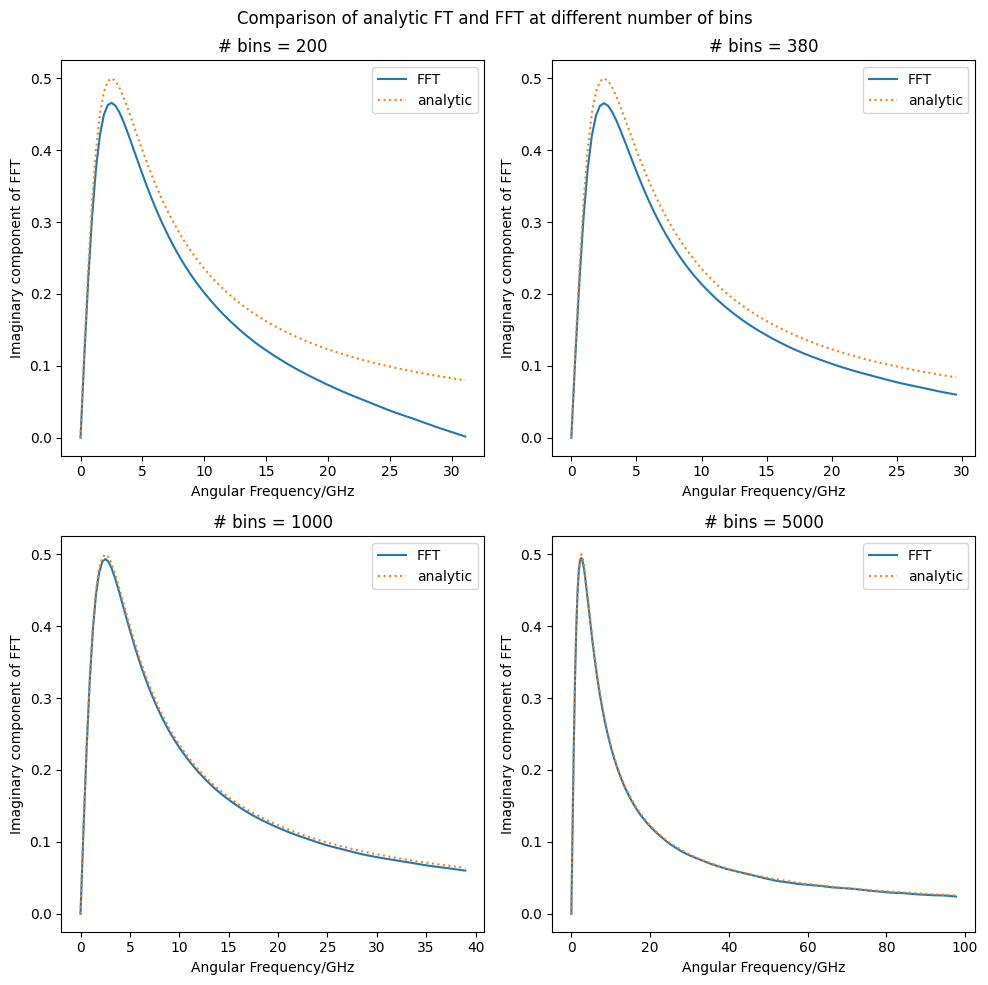

In [4]:
DEMO.MC_exp(multi = False)
n = 1 # select nth  lifetime
fig, ax_bin = plt.subplots(2,2,figsize = (10,10))
ax_bin = np.array(ax_bin).flatten()
n_bins = [200,380,1000,5000]
plt.suptitle('Comparison of analytic FT and FFT at different number of bins')
#Plot FFT of time-domain data with different n_bins
for i in range(len(n_bins)):
    w,p = DEMO.phasor_fft(multi = False,n_bins = n_bins[i]) 
    p = p[n,:]
    end = int(n_bins[i]/2**(i+1))
    ax_bin[i].set_title(f'# bins = {n_bins[i]}')
    ax_bin[i].plot(w[:end],np.imag(p[:end]),label = 'FFT')
    ax_bin[i].plot(w[:end],np.imag(exp_FT(w[:end],DEMO.tau[n])[0]),':',label = 'analytic')
    ax_bin[i].set_xlabel('Angular Frequency/GHz')
    ax_bin[i].set_ylabel('Imaginary component of FFT')
    ax_bin[i].legend()

plt.tight_layout()

Note that the data points do not lie exactly on the universal circle even when the FFT curve (in frequency domnain) is very close to the analytic curve

How to quantify error in position in phasor plot?

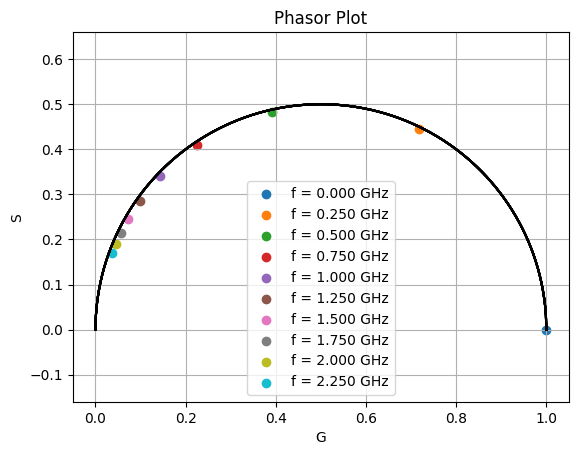

In [13]:
fig,ax = plt.subplots(1,1)
w0 = w[:50:5] #select a few angular frequencies to plot
phasor_plot(ax,w0,p[np.isin(w,w0)])


Fourier transform of a mono-exponential gives 
$$\mathcal{F(e^{-t/\tau})} = \frac{\tau + i \omega}{1+(\tau\omega)^2}$$
Phasor in the complex plane is defined as:
$$z = \mathcal{F(I(t))}/\int_0^\infty I(t) dt = \int_0^\infty I(t)e^{i\omega t} dt/\int_0^\infty I(t) dt$$

Recall multiexponetial decay of the form $$I(t) = \sum_i A_i \exp(-t/\tau_i)$$
Phasor of multi-exponential decay is given by:
$$z = \sum_i \frac{A_i}{\sum_n A_n\tau_n}\cdot\frac{\tau_i + i \omega}{1+(\tau_i\omega)^2}$$

### Decomposing mult-exponential decays using phasors

In [14]:
phasor_df = pd.DataFrame()
for i in range(3):
    sim = sim_list[i]
    w,phasor = sim.phasor_fft(n_bins = 380) #generate phasors
    sol = phasor_solve(w,phasor) #solution
    sol = {str(k):v for k,v in sol.items()} #convert symbols to string
    phasor_df = pd.concat([phasor_df,pd.DataFrame(sol, index=[i])]) #concatenate the results into 1 dataframe

### Repeating simulations for 100 times to observe the effect of noise on the distribution of phasor coordinates and solutions

In [164]:
def sim_repeat_phasor_bi_exp(sim,n=200,num=True):
    '''Input: 
       sim    Simulation class object
       n      number of repeats
       num    True for numerical solution, False for analytic solution
       Output:
       phasor_df DataFrame to store parameters of bi-exponential decays'''
    phasor_df = pd.DataFrame()
    for i in range(200):
        sim.multi_exp_data() #generate a new decay each time
        w,phasor = sim.phasor_fft(MC = False, n_bins = 380) #generate phasors
        sol = phasor_solve(w,phasor,num = num, guess = list(sim.amp)+sim.tau) #solution
        sol = {k:v for k,v in zip(['A1','A2','t1','t2'],sol)} #convert solution to dict 
        phasor_dict = {str(round(w[i]/np.pi/2,2)):phasor[i] for i in range(1,5)} #record the phasor positions
        sol.update(phasor_dict)# append dictionary
        phasor_df = pd.concat([phasor_df,pd.DataFrame(sol, index=[i])]) #concatenate the results into 1 dataframe
        return phasor_df

In [154]:
phasor_df = sim_repeat_phasor_bi_exp(NADH,n=200,num=True)
phasor_df

,A1,A2,t1,t2,0.05,0.1,0.15,0.2
0,0.777,0.223,0.378,4.01,0.534-0.393j,0.336-0.311j,0.268-0.261j,0.23-0.235j
1,0.773,0.227,0.392,4.02,0.534-0.393j,0.336-0.312j,0.268-0.261j,0.229-0.235j
2,0.769,0.231,0.403,4.04,0.533-0.394j,0.335-0.312j,0.267-0.261j,0.229-0.234j
3,0.773,0.227,0.389,4.02,0.534-0.393j,0.336-0.311j,0.268-0.261j,0.229-0.235j
4,0.774,0.226,0.383,4.01,0.534-0.394j,0.336-0.312j,0.268-0.261j,0.229-0.235j
...,...,...,...,...,...,...,...,...
195,0.773,0.227,0.389,4.02,0.534-0.394j,0.336-0.312j,0.267-0.261j,0.229-0.235j
196,0.773,0.227,0.386,4.01,0.535-0.393j,0.336-0.312j,0.268-0.261j,0.229-0.235j
197,0.777,0.223,0.375,4.01,0.534-0.393j,0.335-0.311j,0.268-0.26j,0.23-0.235j
198,0.774,0.226,0.382,4.01,0.535-0.393j,0.336-0.312j,0.268-0.261j,0.23-0.235j


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/lib/histograms.py:841: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


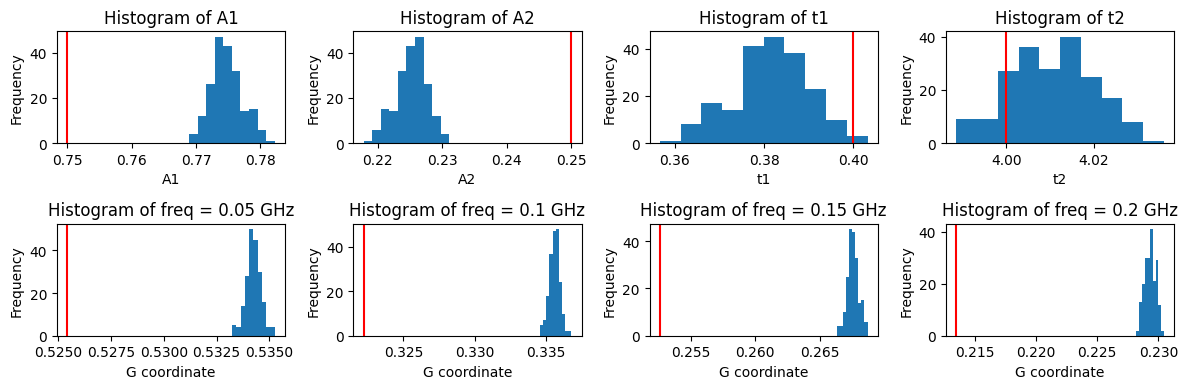

In [155]:
# Create subplots with the desired number of rows and columns
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 4))
axes = np.array(axes).flatten()
# Iterate over each column in the DataFrame
true_list = list(sim.amp)+sim.tau+[]
for i, column in enumerate(phasor_df.columns):
    # Plot the histogram on the corresponding axis
    axes[i].hist(phasor_df[column], bins=10)  # Adjust the number of bins as needed
    axes[i].axvline(true_list[i],c = 'r')
    # Set the title and labels for the plot
    axes[i].set_title(f"Histogram of {column}")
    axes[i].set_xlabel(column)
    if i>3:
        axes[i].set_title(f"Histogram of freq = {column} GHz")
        axes[i].set_xlabel('G coordinate')
    axes[i].set_ylabel("Frequency")

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

In [216]:
def phasor_solve(w,phasor,n=2,num = False,guess=None):
    '''Solve for samplitudes and lifetimes from simulated phasor coordinates
       Input: w        angular frequency array
              phasor   output from phasor_fft
              n        number of components (Default 2)
              num      True for numerical solution, False for analytic solution
              guess    guess for numerical solution'''
    # Define the variables and symbols
    A = symbols('A1:%d' % (n+1)) #amplitudes
    t = symbols('t1:%d' % (n+1)) #lifetimes

    equations = [sum([A[j]for j in range(n)])-1]
    At_sum = sum([A[j]*t[j]for j in range(n)])

    # Generate the equations using different angular frequencies
    for i in range(1,2*n):
        equation = sum([A[j]*t[j]/At_sum/ ((w[i] * t[j])**2 + 1) for j in range(n)]) - np.real(phasor)[i] #g coordinate of phasor
        equations.append(equation)

    # Solve the system of equations
    if num == True:
        solution = nsolve(equations,[n for n in A]+[n for n in t],guess, solver='bisect')
        solution = np.concatenate(np.array(solution).astype(float)) #1d array
    else:
        solution = solve(equations)[0]
        solution = {str(k):float(v) for k,v in solution.items()} #convert symbols to string
    return solution

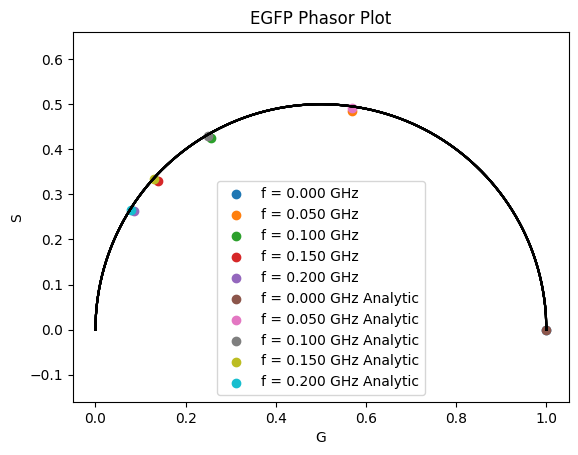

In [8]:
fig,ax = plt.subplots()
phasor = EGFP.phasor
phasor_true = multi_exp_FT(w,EGFP.amp,EGFP.tau) 
phasor_plot(ax,w[:5],phasor)
phasor_plot(ax,w[:5],phasor_true)
ax.set_title('EGFP Phasor Plot')
h,l = ax.get_legend_handles_labels()
l[5:] = [val + ' Analytic' for val in l[5:]]
ax.legend(h,l)

In [11]:
phasor_sol = []
for sim in sim_list:
    if sim != EGFP : #EGFP needs a much higher tolerance for the numerical method
        w,phasor = sim.phasor_fft(MC=False)
        true_par = list(sim.amp)+sim.tau #true parameters
        phasor_sol.append(phasor_solve(w,phasor,num = True ,guess = true_par))#solve for the true phasor
        print(phasor_sol[-1])
        print(true_par)



[0.77109836 0.22890164 0.3887142  4.00345289]
[0.75, 0.25, 0.4, 4]
[0.68010776 0.31989224 1.25206995 2.15882262]
[0.83, 0.17, 1.43, 2.38]


Note the solver fails to resolve EGFP with low tolerance. Need to adjust tolerance to solve for EGFP or another guess\
The numerical solution is very inaccurate too (amplitude 1.12>1)

In [20]:
sim = EGFP
true_par = list(sim.amp)+sim.tau #true parameters
EGFP_sol = phasor_solve(w,EGFP.phasor,num = True ,guess = [0.9,0.1,2.7,10])
print(EGFP_sol)
print(true_par)

[ 1.12046325 -0.12046325  2.82802564 -0.91588584]
[0.503, 0.497, 3.07, 2.43]


### Applying the phasor_solve method to analytic phasor position to check the accuracy of solver

In [21]:
def multi_exp_FT(omega,A,tau):
    '''Analytic solution to Fourier Transform (normalized, i.e. divided by int_0^infty exp(-t/tau)dt) 
    of multi exponential decay with components lifetime tau
    Input:
    omega     angular frequency array
    A         amplitude array
    tau       lifetime'''
    coeff = A*tau/np.sum(A*tau) #coefficient of the sum of mono_exp_FT
    mono_arr = exp_FT(omega,tau)#array of FT of each lifetime
    return np.dot(coeff,mono_arr)

true_sol = []
for sim in sim_list:
    phasor_true = multi_exp_FT(w,sim.amp,sim.tau) #generates analytic phasor position
    true_sol.append(phasor_solve(w,phasor_true,num = True ,guess = list(sim.amp)+sim.tau) )#solve for the true phasor

In [22]:
#print true original values
print('------phasor_solve------')
for sim in sim_list:
    print(list(sim.amp)+sim.tau)
print('--------Original--------')
#print phasor_solve solutions
for sol in true_sol:
    print(sol)

------phasor_solve------
[0.75, 0.25, 0.4, 4]
[0.503, 0.497, 3.07, 2.43]
[0.83, 0.17, 1.43, 2.38]
--------Original--------
[0.75 0.25 0.4  4.  ]
[0.503 0.497 3.07  2.43 ]
[0.83 0.17 1.43 2.38]


The output gives almost exact values of the parameters used despite being a numerical solution.



```python
phasor_solve method:
          A1    A2    tau1  tau2
NADH:    [0.75  0.25  0.4   4.]
EGFP:    [0.503 0.497 3.07  2.43]
mCherry: [0.83  0.17  1.43  2.38]
```

```python
Original:
NADH:    [0.75  0.25  0.4   4.]
EGFP:    [0.503 0.497 3.07  2.43]
mCherry: [0.83  0.17  1.43  2.38]
```